## 아기울음 소리 분류 모델: LSTM

음성은 이미지와 달리 연속성을 가진다. 이에 시계열적 정보 추출에 특화된 LSTM 아키텍쳐를 가지는 모델을 설계하여 아기울음 소리 분류를 수행하고자 한다.

본 문서는 아기울음 소리 원인 분류를 위해 LSTM 모델 정의 및 학습, 예측을 수행하는 내용을 담고 있다.

> LSTM 모델의 정확도는 76%로 최종적으로 사용된 모델인 ResNet50보다 17% 낮은 정확도를 보인다.


In [2]:
# Load packages
import os
import sys
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.stats import skew
from typing import Optional, Union
from sklearn.model_selection import train_test_split
from scipy.stats import kurtosis, median_abs_deviation

In [ ]:
# 경로 설정
main_path = '/Users/jaewone/developer/tensorflow/baby-cry-classification'
data_path = os.path.join(main_path, 'data')
csv_path = os.path.join(main_path, 'origin_data_info.csv')
state_list = ['sad', 'hug', 'diaper', 'hungry',
              'sleepy', 'awake', 'uncomfortable']

sys.path.append(main_path)

In [4]:
# Load custom packages
from utils.os import *
from utils.sound import *
from trans_data.get_state_list import get_state_file_list

In [1]:
# 파이퍼 파라미터

# 모델의 Epochs
EPOCHS = 400

In [6]:
def get_mfcc(file_path,
             sampling_freq=16000,
             mfcc_coef=40,
             mfcc_coef_retain=25,
             mfcc_window_duration=0.0232):
    """
    오디오 파일에 대한 MFCC를 분석한 뒤 값을 반환한다.

    Parameters:
        file_path:            오디오 파일의 경로
        sampling_freq:        sampling rate
        mfcc_coef:            frame의 길이를 결정하는 파라미터.
        mfcc_coef_retain:     유지되는 MFCC 값의 길이
        mfcc_window_duration: 데이터를 읽을 때 겹쳐 읽는 길이(sec)

    Returns:
        list[0]: 초반 mfcc_coef_retain 만큼의 MFCC 값
        list[1]: 평균, 분산, 표준편차와 같은 MFCC의 특성값
    """

    # load wav file and normalize
    wave, sr = librosa.load(file_path, mono=True, sr=sampling_freq)
    wave = librosa.util.normalize(wave)

    # feature extraction
    mfccs = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=mfcc_coef, hop_length=int(
        mfcc_window_duration*sr/2.0), n_fft=int(mfcc_window_duration*sr))

    # 정규화: 평균이 0, 표준편차 1
    mfccs = (mfccs - np.mean(mfccs))/np.std(mfccs)

    # keep the first mfcc_coef_retain coefficients
    mfccs = mfccs[:mfcc_coef_retain, :]

    # calculate MFCC statistics
    mfccs_min = mfccs.min(axis=1)
    mfccs_max = mfccs.max(axis=1)
    mfccs_median = np.median(mfccs, axis=1)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_var = np.var(mfccs, axis=1)
    mfccs_skewness = skew(mfccs, axis=1)
    mfccs_kurtosis = kurtosis(mfccs, axis=1)
    mfccs_mad = median_abs_deviation(mfccs, axis=1)

    mfccs_first_derivative = np.diff(mfccs, n=1, axis=1)
    mfccs_first_derivative_mean = np.mean(mfccs_first_derivative, axis=1)
    mfccs_first_derivative_var = np.var(mfccs_first_derivative, axis=1)

    mfccs_second_derivative = np.diff(mfccs, n=2, axis=1)
    mfccs_second_derivative_mean = np.mean(mfccs_second_derivative, axis=1)
    mfccs_second_derivative_var = np.var(mfccs_second_derivative, axis=1)

    mfccs_stats = np.vstack((mfccs_min, mfccs_max, mfccs_median, mfccs_mean, mfccs_var, mfccs_skewness, mfccs_kurtosis, mfccs_mad,
                            mfccs_first_derivative_mean, mfccs_first_derivative_var, mfccs_second_derivative_mean, mfccs_second_derivative_var))

    return pd.Series([mfccs, mfccs_stats.transpose()])

### 각각의 파일을 불러와 DataFrame으로 변환한다.


In [9]:
file_list = get_state_file_list(data_path)

df = pd.DataFrame({'file': file_list})
df['duration'] = df['file'].apply(lambda file: get_duration(file))
df['file'] = df['file'].apply(lambda file: file.rsplit('/', 1)[1])
df['state'] = df['file'].apply(
    lambda file: file.split('_', 1)[0]).astype('category')
df.tail(3)

,file,duration,state
10938,uncomfortable_135.wav,2.0,uncomfortable
10939,uncomfortable_121.wav,2.0,uncomfortable
10940,uncomfortable_647.wav,2.0,uncomfortable


### 각각의 음성에서 MFCC값을 추출한다.


In [11]:
# Get MFCC data
tqdm.pandas()
df[['mfccs', 'mfccs_stats']] = df.progress_apply(lambda x: get_mfcc(
    os.path.join(data_path, x['state'], x['file'])), axis=1)

# state 열을 카테고리 타입으로 변환한 다음 int 형태로 캐스팅한다.
df.state = df.state.astype('category')
df = df.assign(state_code=df.state.cat.codes)
df.info()

100%|██████████| 10941/10941 [42:16<00:00,  4.31it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10941 entries, 0 to 10940
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   file         10941 non-null  object  
 1   duration     10941 non-null  float64 
 2   state        10941 non-null  category
 3   mfccs        10941 non-null  object  
 4   mfccs_stats  10941 non-null  object  
 5   state_code   10941 non-null  int8    
dtypes: category(1), float64(1), int8(1), object(3)
memory usage: 449.1+ KB


### 추출된 MFCC를 이용하여 모델 학습을 수행한다.


In [24]:
def split_xy(df: pd.DataFrame):
    """
    추출된 MFCC는 독립변수인 x로 구성하며 state(상태)인 state_code는 종속변수 y로 구성하여 반환한다.
    """
    x = np.array(df['mfccs_stats'].to_list())
    x = x.reshape(x.shape[0], x.shape[1], x.shape[2])

    y = np.array(df['state_code'].to_list())
    y = y.reshape(y.shape[0], 1)

    return x, y


def get_lstm_model(num_classes):
    """
    LSTM 모델을 불러온다.
    """
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(256, return_sequences=True),  # 첫 번째 LSTM 레이어
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.LSTM(128, return_sequences=False),  # 두 번째 LSTM 레이어
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=[
                  'sparse_categorical_accuracy'])

    return model


train, val = train_test_split(df, test_size=0.2)
train, test = train_test_split(train, test_size=0.16)

X_train, Y_train = split_xy(train)
X_val, Y_val = split_xy(val)
X_test, Y_test = split_xy(test)

lstm_model = get_lstm_model(num_classes=10)

history = lstm_model.fit(X_train, Y_train, batch_size=128, epochs=EPOCHS, validation_data=(
    X_val, Y_val), callbacks=[], verbose=0)

accuracy_score = lstm_model.evaluate(X_test, Y_test)

44/44 [==============================] - 0s 4ms/step - loss: 1.7666 - sparse_categorical_accuracy: 0.7630


### Epochs에 따른 모델 학습 정확도와 검증 정확도를 시각적으로 확인한다.


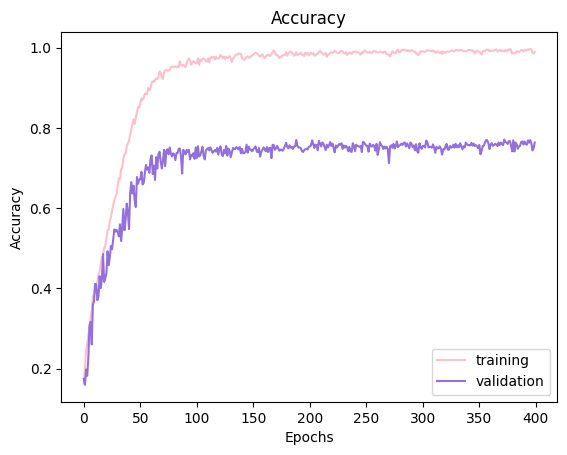

In [27]:
plt.plot(history.history['sparse_categorical_accuracy'],
         label='training', color='pink')
plt.plot(history.history['val_sparse_categorical_accuracy'],
         label='validation', color='mediumpurple')  # 검증 데이터 정확도 추가
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### Test 데이터셋을 통해 모델의 예측 정확도를 도출한다.


In [28]:
from sklearn.metrics import classification_report
lstm_test_preds = lstm_model.predict(X_test)
lstm_test_pred_classes = np.argmax(lstm_test_preds, axis=1)

print(classification_report(Y_test, lstm_test_pred_classes))

44/44 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       238
           1       0.60      0.76      0.67       166
           2       0.82      0.67      0.74       199
           3       0.74      0.79      0.76       185
           4       0.97      0.87      0.92       217
           5       0.73      0.79      0.76       197
           6       0.83      0.77      0.80       199

    accuracy                           0.76      1401
   macro avg       0.77      0.76      0.76      1401
weighted avg       0.77      0.76      0.77      1401

